# Step 2

This is just some more complex experiments of the same nature though. To show the scalability of the previously used methods

In [1]:
from sp_sims.detectors.pearsonneyman import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import argparse
from sklearn.metrics import roc_curve
from math import factorial
from scipy.linalg import expm
import sp_sims
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
from sp_sims.estimators.algos import *
from IPython.display import clear_output
from sp_sims.sanitycheck.truebirthdeath import *
import sp_sims.utils.utils
import random
#from tqdm.notebook import tqdm

from tqdm import tqdm
from time import sleep
import time

In [2]:

importlib.reload(sp_sims.statistics.statistics)
importlib.reload(sp_sims.detectors.pearsonneyman)


<module 'sp_sims.detectors.pearsonneyman' from '/Users/rac716/Research/RL_RateOptimization/sp_sims/detectors/pearsonneyman.py'>

In [3]:
# We may change args here:
class Args:
  xres = 100
  length = 1000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive
  init_state = 0
  num_samples =5
  detection_guesses =1000
args = Args()

In [4]:
def prob_of_path(path,  p0,p1):
    # Take two possible hypothesis
    num = 1
    denum = 1
    for i in range(len(path)-1):
        from_state = path[i]
        to_state = path[i+1]
        num  *= p0[from_state,to_state]
        denum *= p1[from_state,to_state]
    # Return the least preferred one
    return num if denum > num else denum


## Theoretical Error

Basically Calculate:
$$
\begin{align}
P(\epsilon| \Delta) &= \mathbb{E}\left[P(\epsilon|p,\Delta)\right]\\
    &= \mathbb{E}_{\rho\sim P(\rho|\Delta)}\left[\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}\right]
\end{align}
$$
Where $P^{(j)}$ indicates probability of path of wrong hypothesis

In [8]:

# We want to calculate the average error probability for all paths
# We shouldn't be needing paths
from itertools import product

np.random.seed(0)
#np.random.seed(int(time.time()))
#num_steps = args.length
#num_states = args.state_limit+1
num_steps = args.num_samples
num_states = 2

states = np.arange(num_states)
samp_rates = np.logspace(-3,5,args.xres, base=2)
rates0 = {"lam": 4/10,"mu":12/10}
rates1 = {"lam": 100/10,"mu":122/10}

Q0 = generate_true_gmatrix(rates0, args.state_limit)
print(Q0)
Q1 = generate_true_gmatrix(rates1, args.state_limit)


rates = [rates0,rates1]
matrices = [Q0,Q1]

# For Two States
#tgm0 = np.array([[-rates0['lam'],rates0['lam']],[rates0['mu'],-rates0['mu']]])
#tgm1 = np.array([[-rates1['lam'],rates1['lam']],[rates1['mu'],-rates1['mu']]])


hts, sts = ([],[])
last_times  = []
true_values = np.random.choice(2,args.detection_guesses)
# Generate The Tapes
for i in range(args.detection_guesses):
    roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
    #roe = GeneralEmbeddedMarkC(args.length,matrices[true_values[i]])
    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
    hts.append(holdTimes_tape)
    sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Preparation of True Probabilities
true_p0s = []
true_p1s = []
fixed_guesses = np.ones((len(samp_rates), args.detection_guesses))
# Crete all the *known* probability functions.
for srIdx, cur_samp_rate in enumerate(samp_rates):
    true_p0s.append(expm(Q0*(1/cur_samp_rate)))
    true_p1s.append(expm(Q1*(1/cur_samp_rate)))

# Generate
# TODO decrease memory consumption by only using iterators
paths = np.array(list(product(states, repeat=num_steps-1)))
paths = np.concatenate([np.repeat([[0]],repeats=paths.shape[0], axis=0), paths], axis=1)
probs = []

# Sum them up and that should be your probability 
for srIdx, cur_samp_rate in enumerate(samp_rates):
    probs.append(np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))
    #probs.append((1/2)*np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))


[[-0.4  0.4]
 [ 1.2 -1.2]]


## Numerical Error

In [9]:

# Redo the testing experiments
np.random.seed(0)
hts, sts = ([],[])
last_times  = []

base_samp_rate = samp_rates[-1]

for i in range(args.detection_guesses):
    roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
    #roe = GeneralEmbeddedMarkC(args.length,matrices[true_values[i]])
    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
    hts.append(holdTimes_tape); sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Go Over the Detection Guesses
guesses = np.zeros((len(samp_rates), args.detection_guesses))
min_length = np.inf
for i in tqdm(np.arange(args.detection_guesses)):
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        # Fetch Values for Current Rate
        true_p0 = true_p0s[srIdx]
        true_p1 = true_p1s[srIdx]
        
        
        #LG: How many of the baseline intervals fit into the slow rate interval
        decimateInterval = int(base_samp_rate/cur_samp_rate)

        ##tmpSampTapel = quick_sample(cur_samp_rate, sts[i],hts[i])
        ##limited_sampled_tape = tmpSampTapel[0:args.num_samples]
        
        tmpSampTape, replicas = quick_sample_budget(cur_samp_rate, sts[i],hts[i], budget= args.num_samples)
        # Limit the Sample
        ############################################
        # Option 2 with limited number of samples ##
        ############################################

        ##meep = take_a_guess(limited_sampled_tape,true_p0, true_p1)
        moop = multiplicity_guess(tmpSampTape,replicas, true_p0, true_p1)
        guesses[srIdx, i] = moop

        #if meep != moop:
            #print('Ooops')
            #exit(-1)
        #assert meep == moop

num_negs = np.sum(true_values == 0)#TN + FP
num_pos = np.sum(true_values == 1)#TP + FN
#print("Min Length reached is ", min_length)

fprs,fnrs = ([],[])
t1s,t2s = ([],[])
hit_rates = []

# Calculate Probability of Error
for srIdx, cur_samp_rate in enumerate(samp_rates):
    guess = guesses[srIdx]
    hits_index = (true_values == guess)
    neg_guess = guess == 0
    pos_guess = guess == 1
    tp = (true_values[hits_index] == 1).sum()
    tn = (true_values[hits_index] == 0).sum()

    #t1s.append((num_pos-tp)/tn)/(0.5)
    t1s.append((num_negs-tn)/num_negs)/(0.5)
    t2s.append((num_pos-tp)/num_pos)/(0.5)
    #t2s.append((num_negs-tn))

    # False Positive and Negative Rates
    fprs.append((num_negs-tn)/(num_negs))
    fnrs.append((num_pos-tp)/(num_pos))# Type 2 Error
    num_hits = (true_values == guess).sum()
    hit_rates.append(num_hits/args.detection_guesses)
fprs = np.array(fprs)
fnrs = np.array(fnrs)
#tot_error = fprs+ fnrs
t1s = np.array(t1s)
t2s = np.array(t2s)
tot_error = t1s + t2s


100%|██████████| 1000/1000 [00:04<00:00, 240.88it/s]


Minimum Error is obtained at 11.039833162105994
This show that the summation of both errors is closer to monotonicity than having peaks.


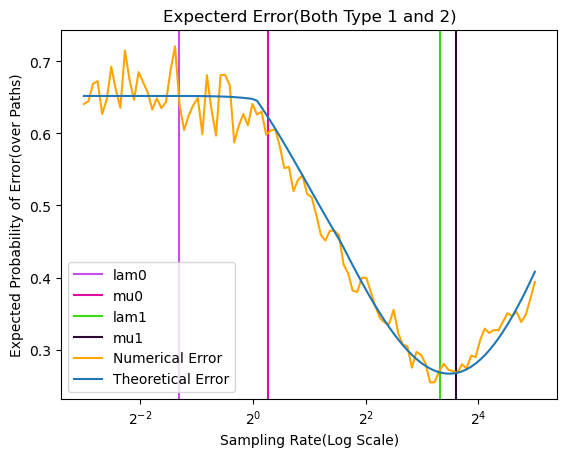

In [10]:
ratess = {"lam0":4/10,"mu0":12/10,"lam1":100/10,"mu1":122/10}
for k,v in ratess.items():
    plt.axvline(x=v,label=k,c=np.random.rand(3,))

plt.plot(samp_rates, tot_error, color='orange', label='Numerical Error')
plt.plot(samp_rates, probs, label='Theoretical Error')
plt.title('Expecterd Error(Both Type 1 and 2)')
print('Minimum Error is obtained at {}'.format(samp_rates[np.argmin(probs)]))
plt.xscale('log', base=2)
plt.legend()
plt.xlabel('Sampling Rate(Log Scale)')
plt.ylabel('Expected Probability of Error(over Paths)')
print('This show that the summation of both errors is closer to monotonicity than having peaks.')
plt.show()